In [1]:
'''
In this Jupyter notebook, I'll implement the K-means clustering algorithm on the Absenteeism dataset found from UCI:
https://archive.ics.uci.edu/ml/machine-learning-databases/00445/
The implementation will make use of PySpark.

I'll be using a tutorial found here:
https://rsandstroem.github.io/sparkkmeans.html
'''

"\nIn this Jupyter notebook, I'll implement the K-means clustering algorithm on the Absenteeism dataset found from UCI:\nhttps://archive.ics.uci.edu/ml/machine-learning-databases/00445/\nThe implementation will make use of PySpark.\n\nI'll be using a tutorial found here:\nhttps://rsandstroem.github.io/sparkkmeans.html\n"

In [2]:
# Get imports
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext


In [3]:
# Import data into pands Dataframe and preview it
path = '/home/nyasarturk1/Documents/Assignment 3/Absenteeism_at_work_AAA/Absenteeism_at_work.xls'
data = pd.read_excel(path, delimiter=";")
data.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239554,...,0,1,2,1,0,1,90,172,30,2


In [4]:
'''
We'll be implementing K-means to create 3 clusters out of this data in the hopes that
the unsupervised learning algorithm will be able to detect similarities amongst the groups (perhaps
we may be able to generalize 'grit' from the clusters based on the range of values for respective categories?).
It has 21 categories (axes/domains) and 740 points (absences recorded).

We need to first eliminate the categorical data- ID (although it is true that many of the recorded absences are due to
the same individual, we will consider each absence individually), Reason for absence, Month of absence,
Day of the Week, Seasons, Disciplinary failure, Education, Social drinker, Social smoker. 
This will leave us with 12 categories.

Also, create column of absence numbers for reference later.
'''

"\nWe'll be implementing K-means to create 3 clusters out of this data in the hopes that\nthe unsupervised learning algorithm will be able to detect similarities amongst the groups (perhaps\nwe may be able to generalize 'grit' from the clusters based on the range of values for respective categories?).\nIt has 21 categories (axes/domains) and 740 points (absences recorded).\n\nWe need to first eliminate the categorical data- ID (although it is true that many of the recorded absences are due to\nthe same individual, we will consider each absence individually), Reason for absence, Month of absence,\nDay of the Week, Seasons, Disciplinary failure, Education, Social drinker, Social smoker. \nThis will leave us with 12 categories.\n\nAlso, create column of absence numbers for reference later.\n"

In [5]:
data = data.drop(columns=['ID','Reason for absence', 'Month of absence', 'Day of the week','Seasons', 
'Disciplinary failure', 'Education', 'Social drinker', 'Social smoker'])

'''
gone_ser = pd.Series([])
for i in range(0, 741):
    gone_ser[i] = ("gone"+str(i))
'''

# Cast data to float
data = data.astype('float')

#!data.insert(0, "GoneNum",gone_ser)

# Ensure our data is fully encapsulated in the DataFrame
data.head()
#!data.shape

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,289.0,36.0,13.0,33.0,239554.0,97.0,2.0,1.0,90.0,172.0,30.0,4.0
1,118.0,13.0,18.0,50.0,239554.0,97.0,1.0,0.0,98.0,178.0,31.0,0.0
2,179.0,51.0,18.0,38.0,239554.0,97.0,0.0,0.0,89.0,170.0,31.0,2.0
3,279.0,5.0,14.0,39.0,239554.0,97.0,2.0,0.0,68.0,168.0,24.0,4.0
4,289.0,36.0,13.0,33.0,239554.0,97.0,2.0,1.0,90.0,172.0,30.0,2.0


In [6]:
# Add a row index as a string
data['goneNum'] = 'gone'+data.index.astype(str)
data.head()

# Save new DataFrame to csv
inpath = '/home/nyasarturk1/Documents/Assignment 3/Absenteeism_at_work_AAA/Absenteeism_.csv'
data.to_csv(inpath, index=False)

In [7]:
# Call SparkContext and initialize SQLContext to give Spark more info on our data
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [8]:
# Initialize clustering model features colummn
FEATURES_COL = ['Transportation expense','Distance from Residence to Work','Service time','Age','Work load Average/day ',
'Hit target','Son','Pet','Weight','Height','Body mass index','Absenteeism time in hours'
]

# Read csv file to SQL Spark
df = sqlContext.read.csv(inpath, header=True) # requires spark 2.0
df.show()

+----------------------+-------------------------------+------------+----+----------------------+----------+---+---+------+------+---------------+-------------------------+-------+
|Transportation expense|Distance from Residence to Work|Service time| Age|Work load Average/day |Hit target|Son|Pet|Weight|Height|Body mass index|Absenteeism time in hours|goneNum|
+----------------------+-------------------------------+------------+----+----------------------+----------+---+---+------+------+---------------+-------------------------+-------+
|                 289.0|                           36.0|        13.0|33.0|              239554.0|      97.0|2.0|1.0|  90.0| 172.0|           30.0|                      4.0|  gone0|
|                 118.0|                           13.0|        18.0|50.0|              239554.0|      97.0|1.0|0.0|  98.0| 178.0|           31.0|                      0.0|  gone1|
|                 179.0|                           51.0|        18.0|38.0|              239554.

In [9]:
# Convert to floats, again (when input to csv, the points were re-converted to strings because the world hates me)
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()


+----------------------+-------------------------------+------------+----+----------------------+----------+---+---+------+------+---------------+-------------------------+-------+
|Transportation expense|Distance from Residence to Work|Service time| Age|Work load Average/day |Hit target|Son|Pet|Weight|Height|Body mass index|Absenteeism time in hours|goneNum|
+----------------------+-------------------------------+------------+----+----------------------+----------+---+---+------+------+---------------+-------------------------+-------+
|                 289.0|                           36.0|        13.0|33.0|              239554.0|      97.0|2.0|1.0|  90.0| 172.0|           30.0|                      4.0|  gone0|
|                 118.0|                           13.0|        18.0|50.0|              239554.0|      97.0|1.0|0.0|  98.0| 178.0|           31.0|                      0.0|  gone1|
|                 179.0|                           51.0|        18.0|38.0|              239554.

In [10]:
# _c0 gives us the row number

# Store features as an array of floats and store this array as a column called "features". Filter out original columns using
#select statement (vectorize input)

vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol='features')
df_kmeans = vecAssembler.transform(df).select('goneNum', 'features')
df_kmeans.show()

+-------+--------------------+
|goneNum|            features|
+-------+--------------------+
|  gone0|[289.0,36.0,13.0,...|
|  gone1|[118.0,13.0,18.0,...|
|  gone2|[179.0,51.0,18.0,...|
|  gone3|[279.0,5.0,14.0,3...|
|  gone4|[289.0,36.0,13.0,...|
|  gone5|[179.0,51.0,18.0,...|
|  gone6|[361.0,52.0,3.0,2...|
|  gone7|[260.0,50.0,11.0,...|
|  gone8|[155.0,12.0,14.0,...|
|  gone9|[235.0,11.0,14.0,...|
| gone10|[260.0,50.0,11.0,...|
| gone11|[260.0,50.0,11.0,...|
| gone12|[260.0,50.0,11.0,...|
| gone13|[179.0,51.0,18.0,...|
| gone14|[179.0,51.0,18.0,...|
| gone15|[246.0,25.0,16.0,...|
| gone16|[179.0,51.0,18.0,...|
| gone17|[179.0,51.0,18.0,...|
| gone18|[189.0,29.0,13.0,...|
| gone19|[248.0,25.0,14.0,...|
+-------+--------------------+
only showing top 20 rows



In [11]:
# Optimize choice of k clusters by clustering a fraction of the data for different choices of k 
#and looking for an "elbow" in the cost function (where the severity of updates per iteration drop off)
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) 
    
# Just to llet you know I understand what K-means is actually doing (since I am using a package to handle the algorithm
#for me), K means starts with k clusters and arbritrarily set k centroids. For each point, the euclidean distance is 
#calculated to each centroid, and the point is assigned to the cluster which it is the shortest distance to.
#Then, iteratively (until we hit max iterations):
# 1.) The new centroid point becomes the new mean for each cluster
# 2.) Each point is reassigned to a new cluster based on shortest Euclidean distance to the new centroids
# 3.) 2 & 3 are repeated

Text(0, 0.5, 'cost')

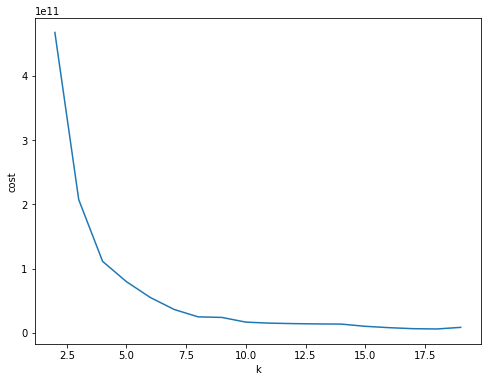

In [12]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [13]:
# It looks like there's little gain after k=10 (which is oddly similar to the tutorial, even though we have 12 features
#whereas the tutorial only has 3).
import time
# Train the model and print out the centroids of the 10 clusters
start_time = time.time()
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)
print("k of 10 training time --- %s seconds ---"%(time.time()-start_time))

Cluster Centers: 
[2.19568000e+02 2.91200000e+01 1.27600000e+01 3.69200000e+01
 2.37464464e+05 9.53280000e+01 1.15200000e+00 5.28000000e-01
 8.01760000e+01 1.72664000e+02 2.68800000e+01 7.18400000e+00]
[2.24827586e+02 3.03448276e+01 1.20689655e+01 3.46896552e+01
 3.43253000e+05 9.50000000e+01 1.65517241e+00 6.20689655e-01
 7.20000000e+01 1.71379310e+02 2.45172414e+01 9.68965517e+00]
[2.21680556e+02 2.94027778e+01 1.19444444e+01 3.63958333e+01
 2.64911576e+05 9.30277778e+01 9.86111111e-01 9.44444444e-01
 7.98402778e+01 1.71604167e+02 2.71388889e+01 6.51388889e+00]
[2.10340426e+02 2.82021277e+01 1.22340426e+01 3.53191489e+01
 3.04894415e+05 9.27127660e+01 8.72340426e-01 5.74468085e-01
 7.69787234e+01 1.71840426e+02 2.60425532e+01 5.94680851e+00]
[2.24193548e+02 2.75483871e+01 1.34193548e+01 3.76129032e+01
 3.27732613e+05 9.74193548e+01 1.32258065e+00 8.06451613e-01
 8.30645161e+01 1.74645161e+02 2.72258065e+01 8.64516129e+00]
[2.3353125e+02 2.9656250e+01 1.3843750e+01 3.7812500e+01 3.782

In [14]:
# Assign each row to a cluster center using transform method to add 'prediction' column to the dataframe. 
#The prediction value is an integer between 0 and k, but it has no correlation to the y value of the input.
transformed = model.transform(df_kmeans).select('goneNum', 'prediction')
rows = transformed.collect()
print(rows[:3])


[Row(goneNum='gone0', prediction=0), Row(goneNum='gone1', prediction=0), Row(goneNum='gone2', prediction=0)]


In [15]:
# Use collect method it is trivial to create a new dataframe using our SQL context
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+-------+----------+
|goneNum|prediction|
+-------+----------+
|  gone0|         0|
|  gone1|         0|
|  gone2|         0|
|  gone3|         0|
|  gone4|         0|
|  gone5|         0|
|  gone6|         0|
|  gone7|         0|
|  gone8|         0|
|  gone9|         0|
| gone10|         0|
| gone11|         0|
| gone12|         0|
| gone13|         0|
| gone14|         0|
| gone15|         0|
| gone16|         0|
| gone17|         0|
| gone18|         0|
| gone19|         6|
+-------+----------+
only showing top 20 rows



In [16]:
# Join the prediction with the original data:
#The features from the original dataframe (data) can be added to the newly created dataframe (df_pred)
#by joining the two dataframes on the 'goneNum' column.
df_pred = df_pred.join(df, 'goneNum')
df_pred.show()

+-------+----------+----------------------+-------------------------------+------------+----+----------------------+----------+---+---+------+------+---------------+-------------------------+
|goneNum|prediction|Transportation expense|Distance from Residence to Work|Service time| Age|Work load Average/day |Hit target|Son|Pet|Weight|Height|Body mass index|Absenteeism time in hours|
+-------+----------+----------------------+-------------------------------+------------+----+----------------------+----------+---+---+------+------+---------------+-------------------------+
|  gone0|         0|                 289.0|                           36.0|        13.0|33.0|              239554.0|      97.0|2.0|1.0|  90.0| 172.0|           30.0|                      4.0|
|  gone1|         0|                 118.0|                           13.0|        18.0|50.0|              239554.0|      97.0|1.0|0.0|  98.0| 178.0|           31.0|                      0.0|
|  gone2|         0|                 179

In [17]:
# Convert Spark dataframe to Pandas dataframe
pddf_pred = df_pred.toPandas().set_index('goneNum')
pddf_pred.head()

,prediction,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Pet,Weight,Height,Body mass index,Absenteeism time in hours
goneNum,,,,,,,,,,,,,
gone0,0,289.0,36.0,13.0,33.0,239554.0,97.0,2.0,1.0,90.0,172.0,30.0,4.0
gone1,0,118.0,13.0,18.0,50.0,239554.0,97.0,1.0,0.0,98.0,178.0,31.0,0.0
gone2,0,179.0,51.0,18.0,38.0,239554.0,97.0,0.0,0.0,89.0,170.0,31.0,2.0
gone3,0,279.0,5.0,14.0,39.0,239554.0,97.0,2.0,0.0,68.0,168.0,24.0,4.0
gone4,0,289.0,36.0,13.0,33.0,239554.0,97.0,2.0,1.0,90.0,172.0,30.0,2.0


In [18]:
list(pddf_pred.columns.values)

['prediction',
 'Transportation expense',
 'Distance from Residence to Work',
 'Service time',
 'Age',
 'Work load Average/day ',
 'Hit target',
 'Son',
 'Pet',
 'Weight',
 'Height',
 'Body mass index',
 'Absenteeism time in hours']

In [19]:
# Rename dataframe columns for visualization
pddf_pred = pddf_pred.rename(index=str, columns={"Transportation expense": "x", "Distance from Residence to Work": "y", "Service time": "z"})

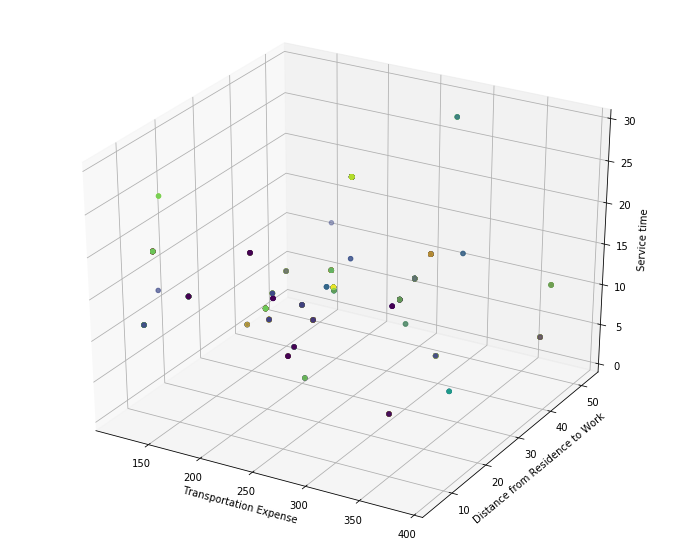

In [20]:
# Visualize results (relatively difficult in 12-D, so we'll attempt to only show the first 3 dimensions):
twelvedee = plt.figure(figsize=(12,10)).gca(projection='3d')
twelvedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
twelvedee.set_xlabel('Transportation Expense')
twelvedee.set_ylabel('Distance from Residence to Work')
twelvedee.set_zlabel('Service time')
plt.show()

In [33]:
# That's a horrible visualization, but it does verify that all of our values are clustered. Let's try another:


# Step 1: evenly distribute each feature among our 5 ranges.
## Rename the remaining variables for easy reference:
##a, b, c, d, e, f, g, h, i, j, k, l for each feature
pddf_pred = pddf_pred.rename(index=str, 
                             columns={"x": "a",
                                      "y": "b",
                                      "z": "c",
                                      "Age":"d",
                                      "Work load Average/day ":"e",
                                      "Hit target":"f",
                                      "Son":"g",
                                      "Pet":"h",
                                      "Weight":"i",
                                      "Height":"j",
                                      "Body mass index":"k",
                                      "Absenteeism time in hours":"l"
                                     })
## Sort each feature into 5 bins using pandas cut
##thanks to: https://www.reddit.com/r/learnpython/comments/73z4e2/pandas_groupby_or_cut_dataframe_to_bins/
### groupby the bins output from pd.cut
a_binList = pd.cut(pddf_pred['a'], 5)
b_binList = pd.cut(pddf_pred['b'], 5)
c_binList = pd.cut(pddf_pred['c'], 5)
d_binList = pd.cut(pddf_pred['d'], 5)
e_binList = pd.cut(pddf_pred['e'], 5)
f_binList = pd.cut(pddf_pred['f'], 5)
g_binList = pd.cut(pddf_pred['g'], 5)
h_binList = pd.cut(pddf_pred['h'], 5)
i_binList = pd.cut(pddf_pred['i'], 5)
j_binList = pd.cut(pddf_pred['j'], 5)
k_binList = pd.cut(pddf_pred['k'], 5)
l_binList = pd.cut(pddf_pred['l'], 5)
### aggregate the results by the count and the sum of the a...l columns
a_binDF = pddf_pred.groupby(a_binList)['a'].agg(['count'])
b_binDF = pddf_pred.groupby(b_binList)['b'].agg(['count'])
c_binDF = pddf_pred.groupby(c_binList)['c'].agg(['count'])
d_binDF = pddf_pred.groupby(d_binList)['d'].agg(['count'])
e_binDF = pddf_pred.groupby(e_binList)['e'].agg(['count'])
f_binDF = pddf_pred.groupby(f_binList)['f'].agg(['count'])
g_binDF = pddf_pred.groupby(g_binList)['g'].agg(['count'])
h_binDF = pddf_pred.groupby(h_binList)['h'].agg(['count'])
i_binDF = pddf_pred.groupby(i_binList)['i'].agg(['count'])
j_binDF = pddf_pred.groupby(j_binList)['j'].agg(['count'])
k_binDF = pddf_pred.groupby(k_binList)['k'].agg(['count'])
l_binDF = pddf_pred.groupby(l_binList)['l'].agg(['count'])
### Set mutually shared row indices
a_binDF=a_binDF.reset_index(drop=True)
b_binDF=b_binDF.reset_index(drop=True)
c_binDF=c_binDF.reset_index(drop=True)
d_binDF=d_binDF.reset_index(drop=True)
e_binDF=e_binDF.reset_index(drop=True)
f_binDF=f_binDF.reset_index(drop=True)
g_binDF=g_binDF.reset_index(drop=True)
h_binDF=h_binDF.reset_index(drop=True)
i_binDF=i_binDF.reset_index(drop=True)
j_binDF=j_binDF.reset_index(drop=True)
k_binDF=k_binDF.reset_index(drop=True)
l_binDF=l_binDF.reset_index(drop=True)
### Concatenate dataframe into single dataframe
col_classes = ['Transportation expense',
               'Distance from Residence to Work',
               'Service time',
               'Age',
               'Work load Average/day ',
               'Hit target',
               'Son',
               'Pet',
               'Weight',
               'Body mass index',
               'Absenteeism time in hours']
print(a_binDF)



   count
0    128
1    276
2    180
3    106
4     50


In [38]:
final_binDF = pd.concat([a_binDF,b_binDF,c_binDF,d_binDF,e_binDF,f_binDF,g_binDF,h_binDF,i_binDF,j_binDF,k_binDF,
                        l_binDF],
                        axis=1) #!columns = col_classes
### Insert column for class names
#!print(final_binDF)
y_lbls = ['Very Low','Low','Med','Hi','Very Hi']

#!final_binDF.insert(0,'Degrees',y_lbls)
final_binDF.columns = [
                       'Transportation expense',
                       'Distance from Residence to Work',
                       'Service time',
                       'Age',
                       'Work load Average/day ',
                       'Hit target',
                       'Son',
                       'Pet',
                       'Weight',
                       'Height',
                       'Body mass index',
                       'Absenteeism time in hours']
final_binDF = final_binDF.rename(index={
    0:'Very Low',
    1:'Low',
    2:'Med',
    3:'Hi',
    4:'Very Hi'
})
print(final_binDF)

          Transportation expense  Distance from Residence to Work  \
Very Low                     128                              159   
Low                          276                               89   
Med                          180                              240   
Hi                           106                               49   
Very Hi                       50                              203   

          Service time  Age  Work load Average/day   Hit target  Son  Pet  \
Very Low            54  263                     160          19  298  598   
Low                312  278                     316          40  229   96   
Med                220  116                     157         124  156   32   
Hi                 147   74                      75         289   15    6   
Very Hi              7    9                      32         268   42    8   

          Weight  Height  Body mass index  Absenteeism time in hours  
Very Low     134     207              103          

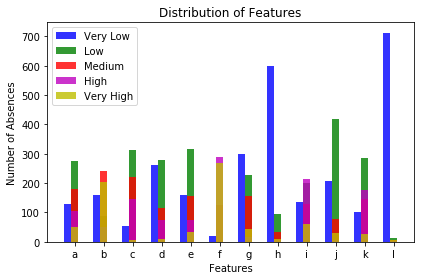

In [43]:
# data to plot
n_groups = 12 #features
 #bars per feature:
vl = final_binDF.iloc[0]
l = final_binDF.iloc[1]
m = final_binDF.iloc[2]
h = final_binDF.iloc[3]
vh = final_binDF.iloc[4]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, vl, bar_width,
alpha=opacity,
color='b',
label='Very Low')
 
rects2 = plt.bar(index + bar_width, l, bar_width,
alpha=opacity,
color='g',
label='Low')

rects3 = plt.bar(index + bar_width, m, bar_width,
alpha=opacity,
color='r',
label='Medium')

rects4 = plt.bar(index + bar_width, h, bar_width,
alpha=opacity,
color='m',
label='High')

rects5 = plt.bar(index + bar_width, vh, bar_width,
alpha=opacity,
color='y',
label='Very High')
 
plt.xlabel('Features')
plt.ylabel('Number of Absences')
plt.title('Distribution of Features')
plt.xticks(index + bar_width, ('a','b','c','d','e','f','g','h','i','j','k','l'))

plt.legend()
 
plt.tight_layout()
plt.show()

In [ ]:
'''
The above graph depicts how many absences per feature fit into our arbitrary range categories.
'''

In [49]:
# data to plot
n_groups = 10 #clusters
#count number of times each prediction appears
c_DF = pddf_pred.groupby('prediction').count()
c_DF = c_DF.drop(columns=['b','c','d','e','f','g','h','i','j','k','l'])
c_DF = c_DF.rename(index=str, columns={"a": "count"})
print(c_DF)

            count
prediction       
0             125
1              29
2             144
3              94
4              31
5              32
6              21
7              97
8              36
9             131


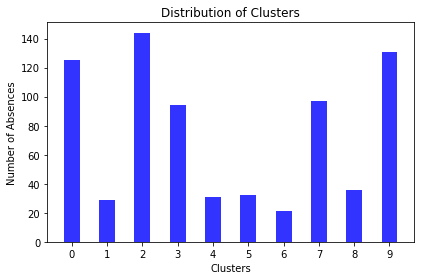

In [66]:
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.45
opacity = 0.8

c =  c_DF.iloc[:,0]

rects1 = plt.bar(index, 
                 c, 
                 bar_width,
                 alpha=opacity,
                 color='b',
                 align='center'
                )
 
 
plt.xlabel('Clusters')
plt.ylabel('Number of Absences')
plt.title('Distribution of Clusters')
plt.xticks(index , ('0','1','2','3','4','5','6','7','8','9'))
 
plt.tight_layout()
plt.show()

In [ ]:
'''
Writeup

---What does the code do---
See comments.

---What are the goals of the program---
We attempted to cluster the Absenteeism at Work data taken
from UCI to see if there were any generalizations would be possible.

---What was your expected result---
I expected the clusters to be even less evenly distributed.

---What issues did you face---
The largest issue I had was visualizing the data and ensuring proper formatting.
I wanted to express the clusters per feature using a single graph, but this proved
impossible.
Additionally, some of the features for this dataset were categorical and therefore
could not be used in the clustering algorithm.

---Analysis of the model you used---

------Benefits------
This quickly and effectively clustered the data into groups.

------Drawbacks------
Kmeans is not a very advanced clustering algorithm in that 
we must specify the number of iterations to run in advance.

---Analysis of the prediction ---
See graphs above.
We see that the clusters are not evenly distributed, as is to be expected.
The clusters seem to take on values which are similar in my arbitrary similarity,
which is to be expected considering how the Kmeans algorithm works.
As is shown by the first graph, most absent times were extremely low, but there was
enough long absent times to be distribute among the rest of the bins.


---How could this be improved---
Greater data visualization and exploration into the absences that comprise each
of the clusters would help tell a better story.
Also, many of the absences came from the same people (grouped by ID),
so perhaps much of this analysis is victim to incorrect data. To mitigate this issue,
perhaps we could group the same IDs and take the average for each feature to increase
the reliability of this analysis.
'''